In [148]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax
import plotly.express as px
import plotly.graph_objects as go

# Problem 1
Suppose the globe tossing data (Chapter 2) had turned out to be 4 water
and 11 land. Construct the posterior distribution, using grid approximation.
Use the same flat prior as in the book

In [93]:
NUM_EXPLANATIONS = 20
explanations = jnp.linspace(0,1,NUM_EXPLANATIONS)
priors = [1/NUM_EXPLANATIONS for i in range(NUM_EXPLANATIONS)]

In [94]:
plausability = jnp.array([
    jnp.exp(dist.Binomial(total_count=15, probs=i).log_prob(4)) 
    for i in explanations])

In [95]:
posterior = jnp.array(plausability) * jnp.array(priors)
posterior = posterior / jnp.sum(posterior)

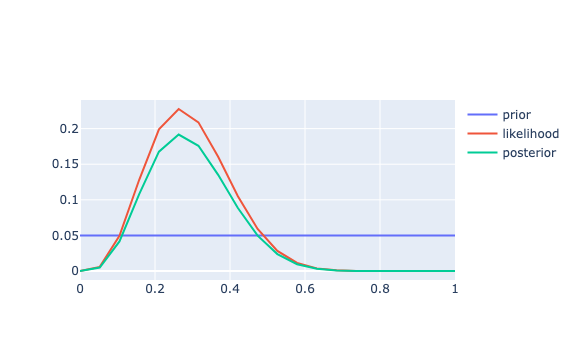

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=explanations, y=priors,
                    mode='lines',
                    name='prior'))
fig.add_trace(go.Scatter(x=explanations, y=plausability,
                    mode='lines',
                    name='likelihood'))
fig.add_trace(go.Scatter(x=explanations, y=posterior,
                    mode='lines',
                    name='posterior'))
fig.show()

# Problem 2
Now suppose the data are 4 water and 2 land. Compute the posterior
again, but this time use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water.

In [97]:
NUM_EXPLANATIONS = 20
explanations = jnp.linspace(0,1,NUM_EXPLANATIONS)
priors = jnp.zeros(NUM_EXPLANATIONS)
priors = prior.at[explanations >= 0.5].set(1)
priors = prior / jnp.sum(prior)

In [98]:
plausability = jnp.array(
    [jnp.exp(dist.Binomial(6, i).log_prob(4)) for i in explanations]
)

In [99]:
posterior = jnp.array(plausability) * jnp.array(priors)
posterior = posterior / jnp.sum(posterior)

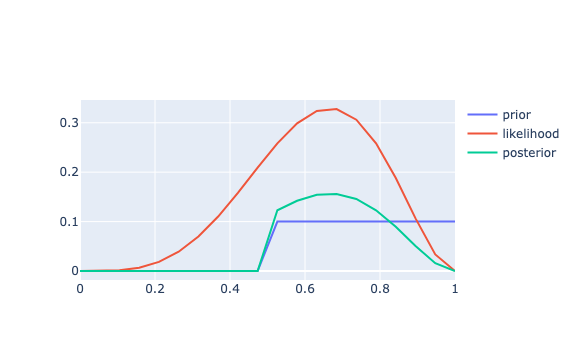

In [100]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=explanations, y=priors,
                    mode='lines',
                    name='prior'))
fig.add_trace(go.Scatter(x=explanations, y=plausability,
                    mode='lines',
                    name='likelihood'))
fig.add_trace(go.Scatter(x=explanations, y=posterior,
                    mode='lines',
                    name='posterior'))
fig.show()

# Problem 3
For the posterior distribution from 2, compute 89% percentile and HPDI
intervals. Compare the widths of these intervals. Which is wider? Why? If you had only the information in the interval, what might you misunderstand about the shape of the posterior distribution?

Now we have computed a posterior distribution. This tells us how confident our golem is over the distribution of explanations.
In order to compute percentile intervals, it would be easier if we had samples from the same distribution instead. Then we could
just go find the values at different percentiles and get percentile intervals. 

Since the number of samples for a given hypothesis will be proportional to the plausability of the hypothesis, the percentile in that array will reflect the percentile in the posterior distribution. I like to think of it as expanding the the posterior distribution.

In [138]:
samples = jax.random.choice(jax.random.PRNGKey(0), a=explanations, p=posterior, shape = (10000,1), replace=True)

To compute a percentile interval we want to choose a mass of the distribution that will contain 89% of the samples, and it must be central. Meaning there must equal sized tails on both sides.

$$ 100-2\alpha = 89$$
$$\alpha = 5.5$$

In [142]:
quantile_80 = jnp.percentile(samples, 94.5)
quantile_10 = jnp.percentile(samples, 5.5)
print(quantile_80, quantile_10)

0.8947368 0.5263158


The HDPI for some $x$th percentile is a percentile interval which will contain $x$% of the probability mass, and it should be constructed by using least number of explanations, meaning we should construct this interval using the most probable range of explanations. Look at this example of below:

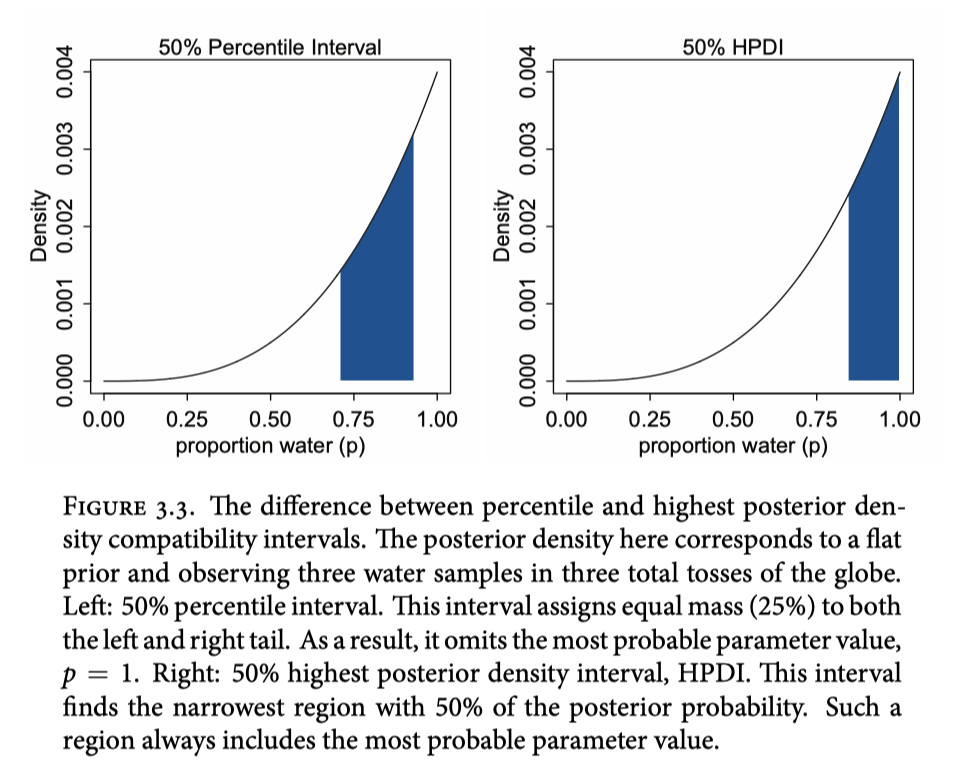

In [145]:
numpyro.diagnostics.hpdi(samples, 0.89)

array([[0.5263158 ],
       [0.84210527]], dtype=float32)

# Problem 4
OPTIONAL CHALLENGE. Suppose there is bias in sampling so that Land
is more likely than Water to be recorded. Specifically, assume that 1-in-5
(20%) of Water samples are accidentally recorded instead as ”Land”. First,
write a generative simulation of this sampling process. Assuming the true
proportion of Water is 0.70, what proportion does your simulation tend to
produce instead? Second, using a simulated sample of 20 tosses, compute
the unbiased posterior distribution of the true proportion of water.

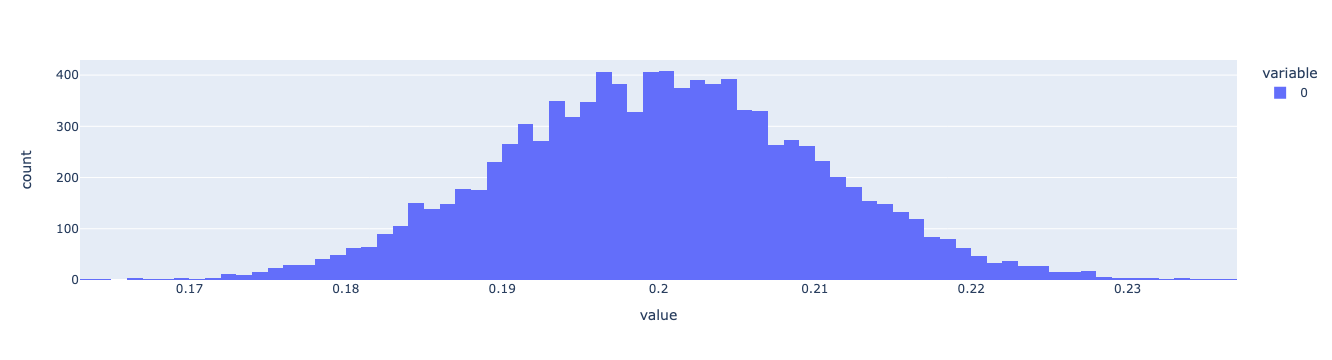

In [395]:
px.histogram(dist.Normal(0.2, 0.01).sample(jax.random.PRNGKey(0),(10000,1)))

In [499]:
# lets simulate the biased sampling procedure and see what we get
# we will use numpyro to do this. we will sample first from a noiseless
# ground truth, then we will sample from a bias distribution which we will
# preferentially select based on the ground truth class.
def model(num_samples=10, water_prob = None, bias_prob = None, observed_data=None):
    if water_prob is None:
        water_prob = numpyro.sample('water_prob', dist.Normal(0.7,0.1))
    if bias_prob is None:
        bias_prob = numpyro.sample('bias_prob', dist.Normal(0.2,0.01))
    categorical_bias = jnp.array([[1.,0.], # 0th index is land and when the sample is land we return the same
                        [bias_prob,1-bias_prob]]) # 1st index is water and when it is water we bias to land 1/5th of the time
    # the plate api sets the variable who should be used as the sample_shape size to broadcast the
    # entire sampling process to. It ensure all numpyro.sample calles will generate the output whose shape
    # is equal to the dimensions provided in the plate variable.
    with numpyro.plate('num_samples',num_samples):
        water_sample = numpyro.sample('ground_truth', dist.Categorical(jnp.array([1-water_prob,water_prob])),infer={'enumerate': 'parallel'})
        water_sample_biased = numpyro.sample('ground_truth_bias', dist.Categorical(categorical_bias[water_sample]), infer={'enumerate': 'parallel'}, obs=observed_data)
        return water_sample_biased

def sampler_gt(num_samples: int):
    with numpyro.handlers.seed(rng_seed=0):
        values = model(num_samples, 0.7,0.2)
        return values

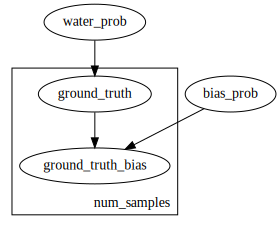

In [500]:
numpyro.render_model(model, (), dict(num_samples=10))

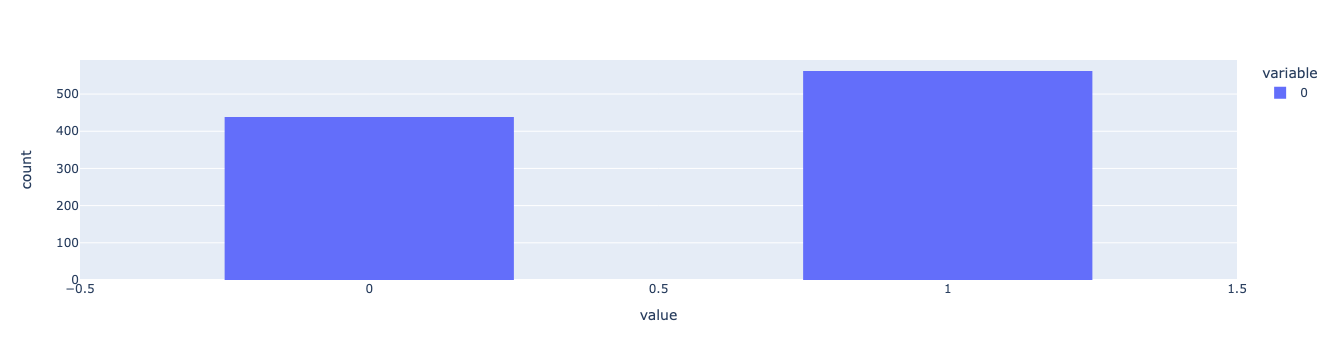

In [501]:
fig = px.histogram(sampler_gt(1000))
fig.update_layout(bargap=0.5)

In [502]:
# now lets do a bayesian update on a prior using this sampler
explanations = jnp.linspace(0,1,NUM_EXPLANATIONS)
priors = jnp.ones(NUM_EXPLANATIONS)/NUM_EXPLANATIONS
samples = sampler(20)
num_water_samples = jnp.sum(samples == 1)
num_land_samples = jnp.sum(samples == 0)
plausability = jnp.array([
    jnp.exp(dist.Binomial(total_count=20, probs=i).log_prob(num_water_samples)) 
    for i in explanations])
posterior = plausability * prior
posterior = posterior / jnp.sum(posterior)

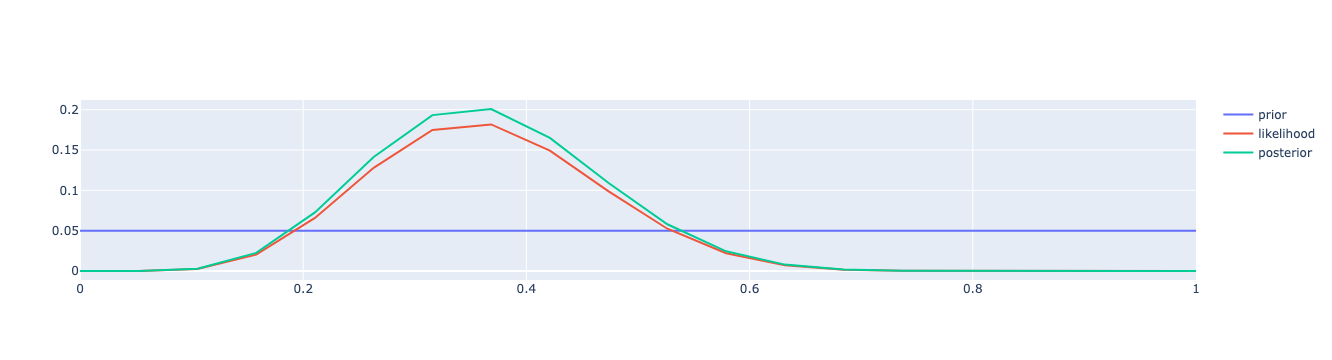

In [503]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=explanations, y=priors,
                    mode='lines',
                    name='prior'))
fig.add_trace(go.Scatter(x=explanations, y=plausability,
                    mode='lines',
                    name='likelihood'))
fig.add_trace(go.Scatter(x=explanations, y=posterior,
                    mode='lines',
                    name='posterior'))
fig.show()

In [504]:
# lets use mcmc to infer the parameters
# sampler gt is conditioned to use 0.7 and 0.2

In [505]:
from numpyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,1000,None, None, sampler_gt(1000), extra_fields=('potential_energy',))

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 882.49it/s, 3 steps of size 7.30e-01. acc. prob=0.93]


In [506]:
mcmc.print_summary() 


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   bias_prob      0.20      0.01      0.20      0.18      0.22    553.68      1.00
  water_prob      0.70      0.02      0.70      0.67      0.74    450.70      1.00

Number of divergences: 0
